In [ ]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import re
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IMPORT

In [ ]:
dbfile = "/content/drive/MyDrive/junior/13_data_clean/chinook.db"
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()


In [ ]:
data = pd.read_sql_query("SELECT invoice.invoice_id, invoice_date, invoice.customer_id,\
 invoice_line.track_id, track.unit_price,\
 CASE WHEN genre.name IN ('Rock', 'Alternative & Punk', 'Metal', 'Alternative', 'Heavy Metal')\
  THEN 'Rock' ELSE 'other' END AS category\
 FROM 'invoice'\
 LEFT JOIN customer ON (invoice.customer_id= customer.customer_id)\
 LEFT JOIN invoice_line ON (invoice.invoice_id= invoice_line.invoice_id)\
 LEFT JOIN track ON (invoice_line.track_id= track.track_id)\
 LEFT JOIN genre ON (track.genre_id= genre.genre_id)\
 LEFT JOIN media_type ON (track.media_type_id = media_type.media_type_id)\
 WHERE invoice.invoice_date >= '2020-01-01'\
 AND invoice.invoice_date <= '2020-12-31'AND media_type.name LIKE '%audio%'\
", conn)
conn.close()

## Data preparation

In [ ]:
data.head()


,invoice_id,invoice_date,customer_id,track_id,unit_price,category
0,465,2020-01-12 00:00:00,21,149,0.99,Rock
1,465,2020-01-12 00:00:00,21,150,0.99,Rock
2,465,2020-01-12 00:00:00,21,151,0.99,Rock
3,465,2020-01-12 00:00:00,21,152,0.99,Rock
4,465,2020-01-12 00:00:00,21,153,0.99,Rock


In [ ]:
data.shape

(1150, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_id    1150 non-null   int64  
 1   invoice_date  1150 non-null   object 
 2   customer_id   1150 non-null   int64  
 3   track_id      1150 non-null   int64  
 4   unit_price    1150 non-null   float64
 5   category      1150 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 54.0+ KB


In [ ]:
#Проверка на дубли

In [ ]:
data[data.duplicated()]

,invoice_id,invoice_date,customer_id,track_id,unit_price,category
382,517,2020-05-16 00:00:00,3,2573,0.99,other
997,593,2020-11-23 00:00:00,12,1042,0.99,other


In [ ]:
data[(data.invoice_id == 593) & (data.track_id == 1042)]

,invoice_id,invoice_date,customer_id,track_id,unit_price,category
989,593,2020-11-23 00:00:00,12,1042,0.99,other
997,593,2020-11-23 00:00:00,12,1042,0.99,other


In [ ]:
df_raw = data.copy()

In [ ]:
#Удаление дубликатов
df_raw = df_raw.drop_duplicates()
df_raw.shape

(1148, 6)

In [ ]:
missing_values = ((df_raw.isna().sum() / len(df_raw)) * 100).sort_values()
missing_values

invoice_id      0.0
invoice_date    0.0
customer_id     0.0
track_id        0.0
unit_price      0.0
category        0.0
dtype: float64

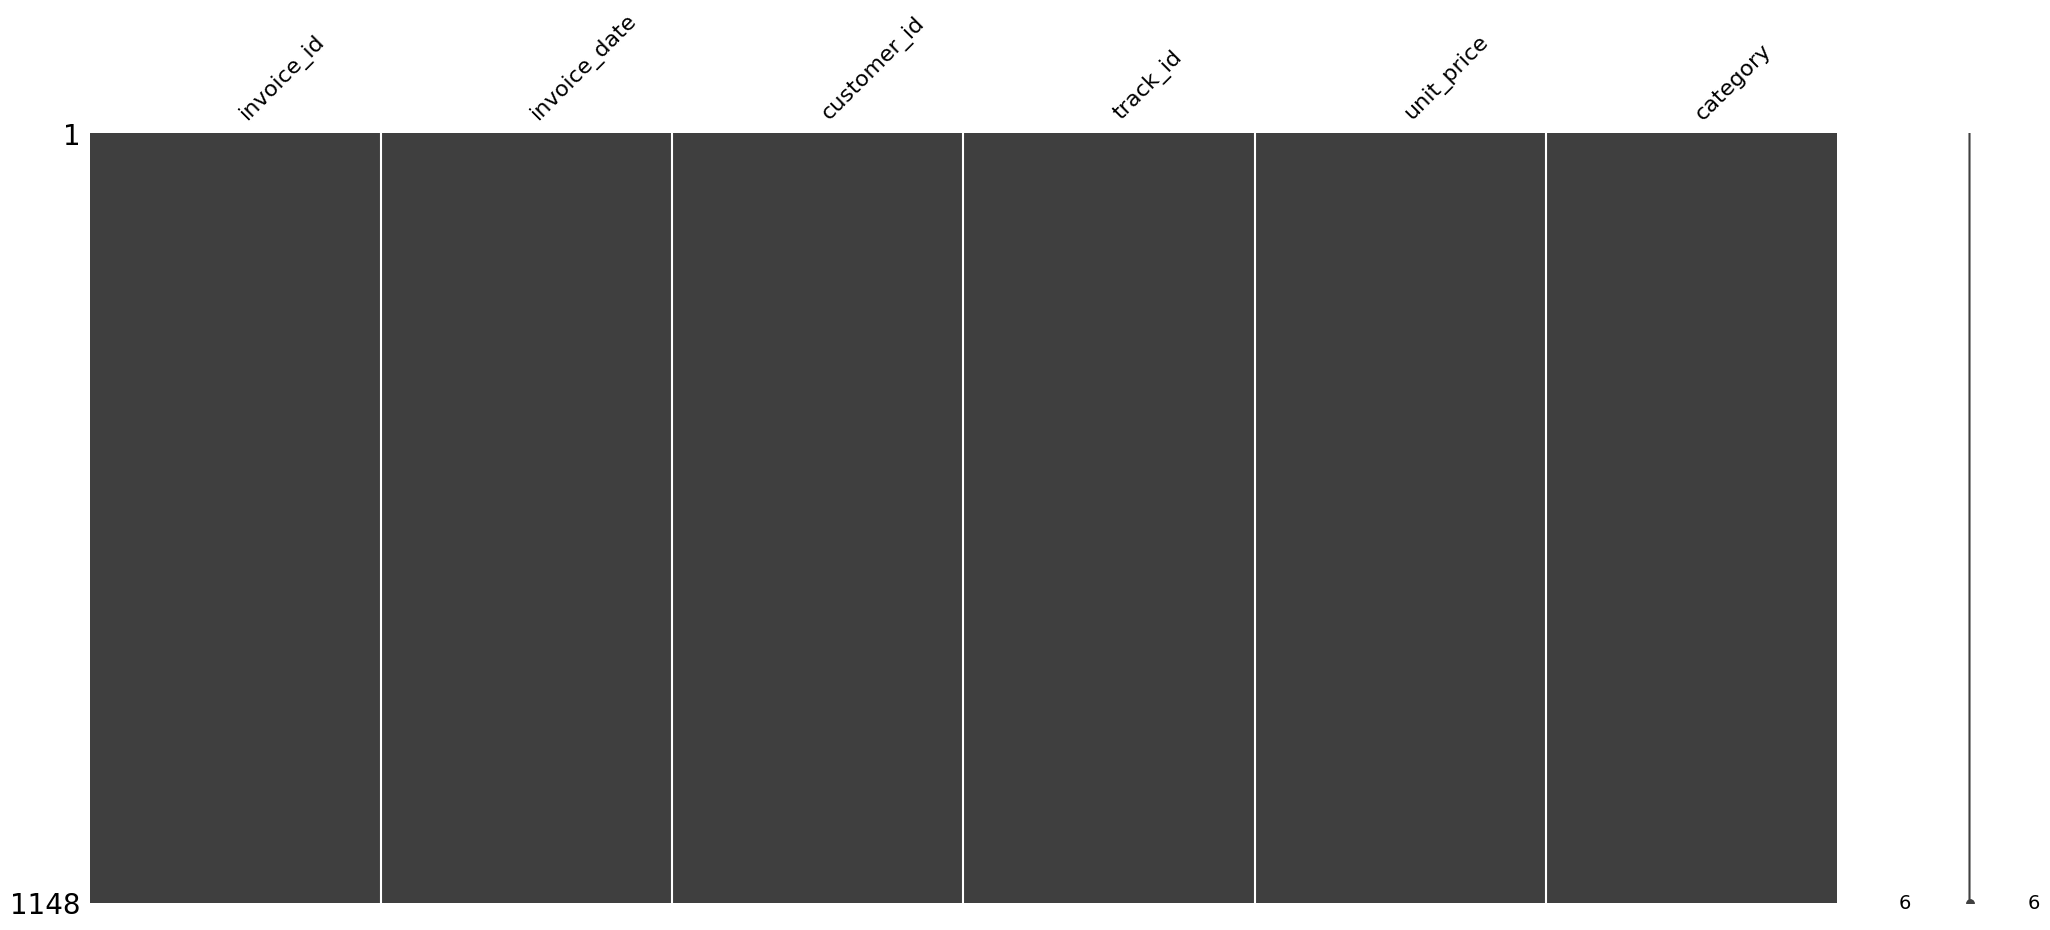

In [ ]:
msno.matrix(df_raw);

## Преобразование признаков

In [ ]:
df_raw['date_month'] = pd.to_datetime(df_raw.invoice_date, yearfirst=True, errors="coerce")

In [ ]:
df_raw['date_month'] = (df_raw['date_month'].dt.floor('d') +
                           pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1))

In [ ]:
df_raw['date_month']

0      2020-01-01
1      2020-01-01
2      2020-01-01
3      2020-01-01
4      2020-01-01
          ...    
1145   2020-12-01
1146   2020-12-01
1147   2020-12-01
1148   2020-12-01
1149   2020-12-01
Name: date_month, Length: 1148, dtype: datetime64[ns]

### Проверка выбросов

In [ ]:
#group_date_df = df_raw.groupby(['date_month']).agg(qty_track=('track_id', 'count'), customer=('customer_id', 'count')).reset_index()
group_date_df = df_raw.groupby(['date_month','category'])['track_id','customer_id','invoice_id'].nunique().reset_index()

<ipython-input-173-15e6074dc2d6>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_date_df = df_raw.groupby(['date_month','category'])['track_id','customer_id','invoice_id'].nunique().reset_index()


In [ ]:
group_date_df.head()

,date_month,category,track_id,customer_id,invoice_id
0,2020-01-01,Rock,37,8,8
1,2020-01-01,other,6,3,3
2,2020-02-01,Rock,90,11,11
3,2020-02-01,other,5,4,4
4,2020-03-01,Rock,57,10,10


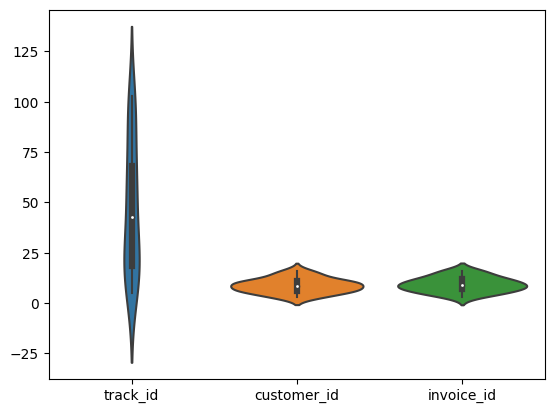

In [ ]:
sns.violinplot(data=group_date_df);

# DATA VIZUALISATION

## Продажи треков в ед
общее количество купленых треков, в разверезе категорий по месяцам



In [ ]:
colors = ['#78c850', '#c86450', '#50b4c8' ,'#a050c8']


In [ ]:
#group_date_df = df_raw.groupby(['date_month','category']).agg(qty_track=('track_id', 'count')).reset_index()
group_date_df = df_raw.groupby(['date_month','category'])['track_id'].nunique().reset_index()

In [ ]:
group_date_df.shape

(24, 3)

In [ ]:
group_date_df.head()

,date_month,category,track_id
0,2020-01-01,Rock,37
1,2020-01-01,other,6
2,2020-02-01,Rock,90
3,2020-02-01,other,5
4,2020-03-01,Rock,57


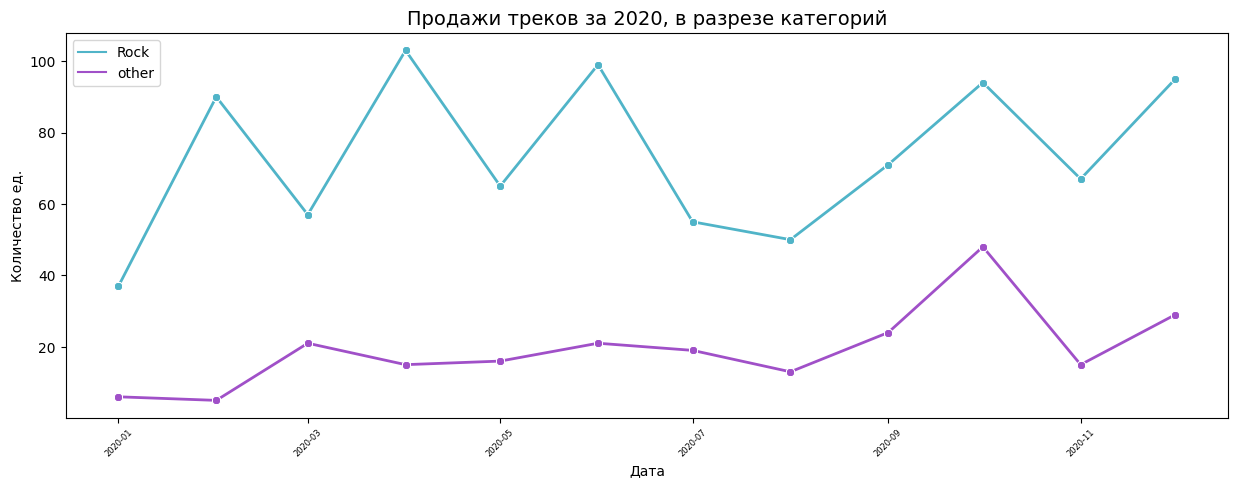

In [ ]:
# Задаем размер графика
plt.figure(figsize=(15,5))
# Рисуем линию
sns.lineplot(x='date_month', y='track_id', data = group_date_df, hue='category', palette=colors[2:], lw=2, marker ='8')
# Заголовок
plt.title('Продажи треков за 2020, в разрезе категорий', fontsize=14)
# Поворачиваем подписи на оси x
plt.xticks(fontsize=6 ,rotation=45)
# Название оси X
plt.xlabel('Дата', fontsize=10)
# Название оси X
plt.ylabel('Количество ед.', fontsize=10)
# Легенда
plt.legend(loc='upper left')
plt.show()

## Количество покупок


In [ ]:
group_date_df = df_raw.groupby(['date_month','category'])['invoice_id'].nunique().reset_index()

In [ ]:
group_date_df.head()

,date_month,category,invoice_id
0,2020-01-01,Rock,8
1,2020-01-01,other,3
2,2020-02-01,Rock,11
3,2020-02-01,other,4
4,2020-03-01,Rock,10


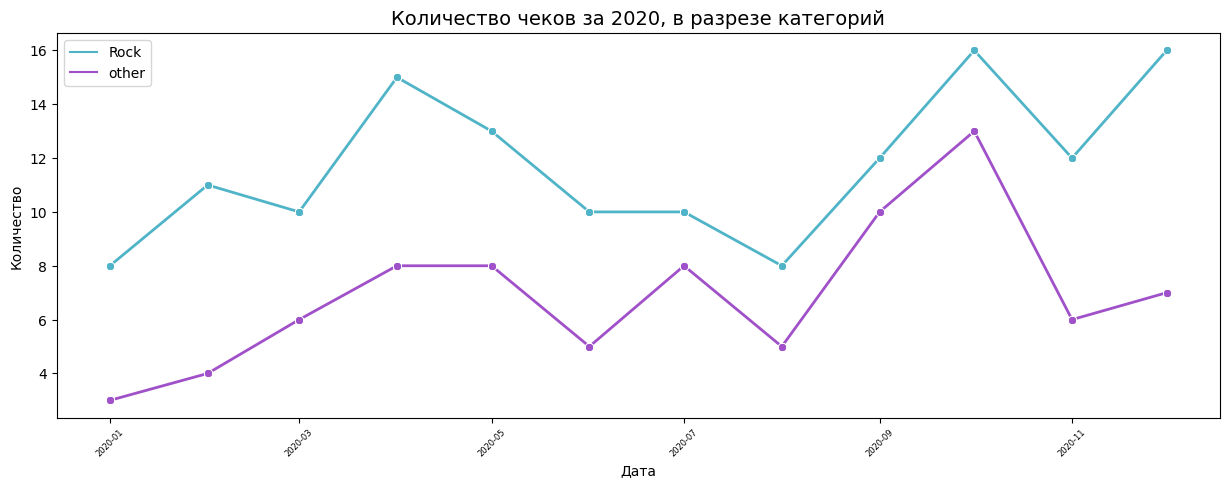

In [ ]:
# Задаем размер графика
plt.figure(figsize=(15,5))
# Рисуем линию
sns.lineplot(x='date_month', y='invoice_id', data = group_date_df, hue='category', palette=colors[2:], lw=2, marker ='8')
# Заголовок
plt.title('Количество чеков за 2020, в разрезе категорий', fontsize=14)
# Поворачиваем подписи на оси x
plt.xticks(fontsize=6 ,rotation=45)
# Название оси X
plt.xlabel('Дата', fontsize=10)
# Название оси X
plt.ylabel('Количество', fontsize=10)
# Легенда
plt.legend(loc='upper left')
plt.show()

## Количество покупателей

In [ ]:

group_date_df = df_raw.groupby(['date_month','category'])['customer_id'].nunique().reset_index()

In [ ]:
group_date_df.head()

,date_month,category,customer_id
0,2020-01-01,Rock,8
1,2020-01-01,other,3
2,2020-02-01,Rock,11
3,2020-02-01,other,4
4,2020-03-01,Rock,10


In [ ]:
# Проверка количество уникальных id чеков и покупателей не должно совпадать иначе вероятна ошибка запроса
df_raw['customer_id'].nunique() == df_raw['invoice_id'].nunique()

False

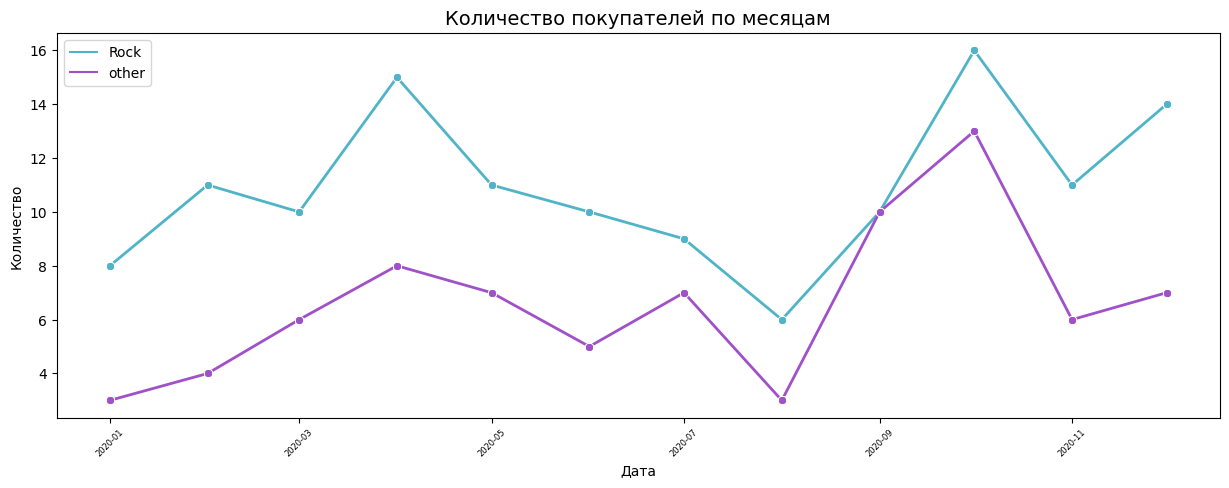

In [ ]:
# Задаем размер графика
plt.figure(figsize=(15,5))
# Рисуем линию
sns.lineplot(x='date_month', y='customer_id', data = group_date_df, hue='category', palette=colors[2:], lw=2, marker ='8')
# Заголовок
plt.title('Количество покупателей по месяцам', fontsize=14)
# Поворачиваем подписи на оси x
plt.xticks(fontsize=6 ,rotation=45)
# Название оси X
plt.xlabel('Дата', fontsize=10)
# Название оси X
plt.ylabel('Количество', fontsize=10)
# Легенда
plt.legend(loc='upper left')
plt.show()

## Выручка

In [ ]:
group_date_df = df_raw.groupby(['category']).agg(qty_track=('unit_price', 'sum')).reset_index()

In [ ]:
group_date_df.head()

,category,qty_track
0,Rock,902.88
1,other,233.64


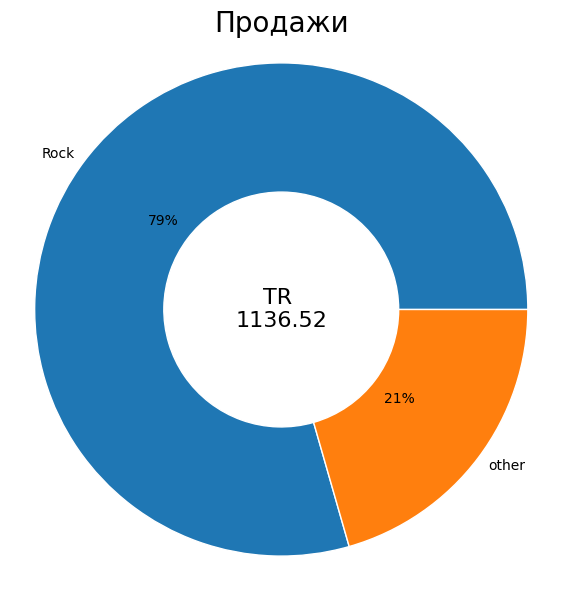

In [ ]:
# Создание объекта графика и осей
fig, ax = plt.subplots(figsize=(7,7))
# Рисуем кпуговую диаграмму
ax.pie(
    x =group_date_df['qty_track'],
    radius=2.1,
    wedgeprops=dict(width=1.1, edgecolor='w'),
    labels = group_date_df['category'],
    labeldistance=1.05,
    autopct='%.0f%%'
)
# Название
ax.set_title('Продажи', loc='center', fontsize=25)
# Равные пропорции x и y
ax.axis("equal")

# Текст посередине
user_count = group_date_df['qty_track'].sum()
sumstr = f'TR \n{user_count}'
ax.text(0., 0., sumstr, horizontalalignment='center', verticalalignment='center', fontsize = 16)
plt.show()

## Conclusion

1) Все треки продаются по одной цене
2) Доля продаж категории рок состовляет почти 80%
3) Продажи в ед стабильны пр этом количество покупателей выросло. Необходим проверить гипотезу о том что средний чек падает.